In [1]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
import pandas as pd
import re
import time
import matplotlib.pyplot as plt
import wget
from bs4 import BeautifulSoup as bs
import requests
import os
from zipfile import ZipFile

In [2]:
def Get_Driver(url = 'https://understat.com/league/EPL'):
    """
    This function enables access to the url 
    """
    driver = webdriver.Chrome('chromedriver.exe')
    driver.get(url)
    return driver;

def Update_Driver(version_rank = 2):
    """
    This function downloads chrome driver from the chrome driver website
    
    version_rank offers a way to modify what version of chrome driver to download
    the defualt value is 2 as the second latest version is usually the latest of the stable versions
    """
    print('Updating driver.....')
    url = 'https://chromedriver.chromium.org/downloads'
    http = requests.get(url).content
    soup = bs(http, 'lxml')
    tags = soup.find_all('a')
    found = 0 # keeps track of how many chrome drivers are found
    for tag in tags: # find tags for the chromedriver download link
        if tag.get('target',None) is not None:
            check_text = tag.text
            if check_text.split(' ')[0] == 'ChromeDriver': # check to make sure the link is for chrome driver 
                found += 1
            if found == version_rank: # found the newest stable version of chromedriver
                chrome_driver = re.findall(r'[\d/.]+',check_text)[0] # extract version number
                break
    download_url = f'https://chromedriver.storage.googleapis.com/{chrome_driver}/chromedriver_win32.zip'
    local_file = 'chromedriver_win32.zip'
    if os.path.exists(local_file):
        os.remove(local_file) # so that only current version is in folder
    zip_file = wget.download(download_url,local_file)
    with ZipFile(zip_file, 'r') as zip:
        for info in zip.infolist():
            file_name = info.filename
            if 'chromedriver' in file_name:
                if os.path.exists(file_name):
                    os.remove(file_name)
                zip.extract(file_name)
    print('\n')
    print(f'driver updated to version {chrome_driver}')

def Get_Table(driver, table_path, wait = 5):
    """
    This function finds the table element found in xpath given
    
    driver: Web browser driver
    table_path: xpath of table
    wait: number of seconds to wait for element to load
    """
    try:
        myElem = WebDriverWait(driver, wait).until(EC.presence_of_element_located((By.XPATH, table_path)))
    except TimeoutException:
        print('Operation timed out, table was not detected')
    return myElem;

def Get_Panel(driver, buttons_path, wait = 5):
    """
    This function finds the buttons panel element found in xpath given
    
    driver: Web browser driver
    buttons_path: xpath of buttons panel
    wait: number of seconds to wait for element to load
    """
    try:
        buttons_panel = WebDriverWait(driver, wait).until(EC.presence_of_element_located((By.XPATH, buttons_path)))
    except:
        print('Operation timed out, buttons were not detected')
    return buttons_panel;

def Get_Headers(myElem, header, data):
    """
    This function takes column header data from a table element, and uses it to update a dictionary for storing the data
    MyElem: table element gotten from the webpage
    header: a dictionary of column headers for the table
    data: Dictionary to store the data collected
    """
    # get column names and update data
    table_header = myElem.find_element(By.TAG_NAME, 'thead')
    headers = table_header.find_elements(By.TAG_NAME, 'th') # these will be the column headers
    for order,field in enumerate(headers):
        field_name = field.text
        if field_name:
            header[order] = field_name
            data[field_name] = list()

def Get_Buttons(buttons_panel):
    buttons = buttons_panel.find_elements(By.TAG_NAME, 'li') # collect the list of page buttons currently available
    return buttons;

def Get_Data(myElem, header, data):
    """
    This function writes data from a table element into a dataframe
    MyElem: table element gotten from the webpage
    header: a dictionary of column headers for the table
    data: Dictionary to store the data collected
    """
    # complete data
    table_body = myElem.find_element(By.TAG_NAME, 'tbody')
    table_rows = table_body.find_elements(By.TAG_NAME, 'tr')
    for row in table_rows:
        columns = row.find_elements(By.TAG_NAME, 'td')
        for index,column in enumerate(columns):
            entry = column.text
            if entry:
                data[header.get(index)].append(entry)
    
def Main(driver): 
    player_header = dict() # get the header fields with their order in the table
    player_data = dict() # get the data in the table
    team_header = dict()
    team_data = dict()
    Ptable_path = './/*[@id="league-players"]/table'
    Ttable_path = './/*[@id="league-chemp"]/table'
    buttons_path = './/*[@id="league-players"]/div[1]/ul'
    get_pages = True
    player_table= Get_Table(driver, Ptable_path)
    buttons_panel = Get_Panel(driver,buttons_path)
    Get_Headers(player_table, player_header, player_data)
    buttons = Get_Buttons(buttons_panel)
    previous_page = 0 # start at page one
    while get_pages:
        get_pages = False # assume this is the last page
        player_table= Get_Table(driver, Ptable_path)
        buttons_panel = Get_Panel(driver, buttons_path)
        buttons = Get_Buttons(buttons_panel)
        for button in buttons:
            page_number = button.find_element(By.TAG_NAME, 'a').text
            try:
                if int(page_number) > previous_page:
                    previous_page = int(page_number)
                    button.click()
                    Get_Data(player_table, player_header, player_data)
                    get_pages = True # keep collecting pages
                    break
            except ValueError: # text of button was not a number
                continue
    team_table = Get_Table(driver, Ttable_path)
    Get_Headers(team_table, team_header, team_data)
    Get_Data(team_table, team_header,team_data)
    driver.close()
    return player_data, team_data;

if __name__ == '__main__':
    try:
        with Get_Driver() as driver:
            player_data, team_data = Main(driver)
    except:
        Update_Driver()
        with Get_Driver() as driver:
            player_data, team_data = Main(driver)

In [3]:
player_stats = pd.DataFrame(player_data)
team_stats = pd.DataFrame(team_data)

## Clean Dataframes

In [5]:
# Certain columns have text that combines two numbers that should be in seperate columns

player_stats[['xG','xG-G']] = player_stats.loc[:,'xG'].str.extract('(\w+\.\w+)((?:\+|\-).+)', expand = True).fillna('0.00')
player_stats[['xA','xA-A']] = player_stats.loc[:,'xA'].str.extract('(\w+\.\w+)((?:\+|\-).+)', expand = True).fillna('0.00')
team_stats[['xG','xG-G']] = team_stats.loc[:,'xG'].str.extract('(\w+\.\w+)((?:\+|\-).+)', expand = True).fillna('0.00')
team_stats[['xGA','xGA-GA']] = team_stats.loc[:,'xGA'].str.extract('(\w+\.\w+)((?:\+|\-).+)', expand = True).fillna('0.00')
team_stats[['xPTS','xPTS-PTS']] = team_stats.loc[:,'xPTS'].str.extract('(\w+\.\w+)((?:\+|\-).+)', expand = True).fillna('0.00')

# convert player columns to appropriate data types

columns_to_integer = ['Apps', 'Min', 'G', 'A']
columns_to_float = ['xG', 'xA', 'xG90','xA90', 'xG-G', 'xA-A']
player_stats[columns_to_float] = player_stats[columns_to_float].astype(float)
player_stats[columns_to_integer] = player_stats[columns_to_integer].astype(int)
player_stats.drop(columns = '№', inplace = True)

# convert team columns to approproate data types

columns_to_integer = ['M','W','D','L','G','GA','PTS']
columns_to_float = ['xG', 'xGA', 'xPTS','xG-G', 'xGA-GA', 'xPTS-PTS']
team_stats[columns_to_float] = team_stats[columns_to_float].astype(float)
team_stats[columns_to_integer] = team_stats[columns_to_integer].astype(int)
team_stats.drop(columns = '№', inplace = True)


# create extra measurements

player_stats['G90'] = round(player_stats['G']*90*0.6/player_stats['Min'],2)
player_stats['A90'] = round(90 * player_stats['A']*0.4/player_stats['Min'],2)
player_stats['xG90'] *= 0.6
player_stats['xA90'] *= 0.4
player_stats['xG90-G90'] = player_stats['xG90'] - player_stats['G90']
player_stats['xA90-A90'] = player_stats['xA90'] - player_stats['A90']
player_stats['G90+A90'] = player_stats['G90'] + player_stats['A90']
player_stats['xG90+xA90'] = player_stats['xG90'] + player_stats['xA90']
player_stats['G+A'] = player_stats['G'] + player_stats['A']
player_stats['xG+xA'] = player_stats['xG'] + player_stats['xA']
player_stats['xG+xA - G+A'] = player_stats['xG-G'] + player_stats['xA-A']
player_stats['G90+A90'] = player_stats['G90'] + player_stats['A90']
player_stats['xG90+xA90 - G90+A90'] = player_stats['xG90-G90'] + player_stats['xA90-A90']

# Choose different colors for the teams
teams = team_stats['Team']
colors = ['red', 'blue','green','yellow','purple','black','orange','brown','lightgreen','lawngreen',\
         'violet','pink','grey','aqua','olive','mistyrose','honeydew','whitesmoke','darkseagreen','ivory','lightgrey']
color_dict = {team:colors[index] for index,team in enumerate(teams)}
# create a dictionary for getting column index
team_columns = {column:index for index,column in enumerate(team_stats.columns)}

# Next Steps

Since the goal of this script is FPL analysis we will be assigning weights to goal and assist stats to reflect the value in FPL.

To reduce variability we will limit our analysis to the following

- goals and assists per 90 minutes
- Players with an appearance that is at least half of the maximum appearance in the data
- Players with at least half the attack output(goals + assists) of the player with the most output

In [6]:
def Get_top(player_stats,sort, ascending = True, min_app = None, top = 15):
    """
    This function simply gives you diferent top 15 players table based on whatever sort you choose 
    """
    if min_app is None:
        min_app = max(player_stats['Apps'])//2
    min_minutes = max(player_stats['Min'])//2 # minimum appearances that are relevant for analysis
    min_output = max(player_stats['G+A'])//3 # minimum attack contributions relevant for analysis
    filters = (player_stats['Min'] >= min_minutes)&(player_stats['G+A'] >= min_output)&(player_stats['Apps'] >= min_app) # this is to reduce variability 
    table = player_stats.sort_values(by = sort, ascending = ascending).loc[filters,:].head(top).copy()
    return table;

# Top 15 Efficient Attackers

A good attacker by this definition is an individual who scores more goals and provides more assists than expected at best and about the same as expected at worst. This is relative to appearances made

In [7]:
efficient = pd.DataFrame(Get_top(player_stats, ['xG90+xA90 - G90+A90','G90+A90'], ascending = (True, False),top = 20)['Player'])
efficient['rank'] = [x for x in range(1,len(efficient) + 1)]
efficient.set_index('rank')                                     

,Player
rank,
1,Kevin De Bruyne
2,Emile Smith-Rowe
3,Mason Mount
4,Emmanuel Dennis
5,Son Heung-Min
6,Andrew Robertson
7,James Ward-Prowse
8,James Maddison
9,Mohamed Salah


# Top 15 Attackers(Actual)

These are the attackers that have contributed the most to attack relative to games played

In [8]:
actual = Get_top(player_stats, ['G90+A90','xG90+xA90'], ascending = False, top = 20)
actual['actual_rank'] = [x for x in range(1,len(actual) + 1)]
actual = actual.loc[:,['Player','Team','actual_rank','xG90+xA90','G90+A90','Apps']].copy()

# Top 15 Attackers(Expected)

These are the attackers that have contributed the most to attack relative to games played theoretically

In [9]:
expected = Get_top(player_stats, 'xG90+xA90', ascending = False, top = 20)
expected['expected_rank'] = [x for x in range(1,len(expected) + 1)]
expected = expected.loc[:,['Player','Team','expected_rank']].copy()

In [10]:
# Find players that are expected to have high contributipons and actually do
summary_stats = expected.merge(actual, how = 'inner')

# a negative spread is underperforming and a positive spread is overperforming
summary_stats['perf_spread'] = round((summary_stats['G90+A90'] - summary_stats['xG90+xA90'])*100/summary_stats['xG90+xA90'],2)
summary_stats['perf_spread'] = summary_stats['perf_spread'].apply(lambda x: f'{x}%')

summary_stats

,Player,Team,expected_rank,actual_rank,xG90+xA90,G90+A90,Apps,perf_spread
0,Mohamed Salah,Liverpool,1,1,0.606,0.64,31,5.61%
1,Diogo Jota,Liverpool,2,3,0.506,0.44,30,-13.04%
2,Cristiano Ronaldo,Manchester United,3,2,0.446,0.45,28,0.9%
3,Raheem Sterling,Manchester City,4,7,0.446,0.36,26,-19.28%
4,Harry Kane,Tottenham,5,8,0.418,0.33,32,-21.05%
5,Sadio Mané,Liverpool,6,9,0.408,0.33,30,-19.12%
6,Son Heung-Min,Tottenham,7,5,0.344,0.43,30,25.0%
7,Phil Foden,Manchester City,8,14,0.334,0.29,24,-13.17%
8,Ivan Toney,Brentford,9,11,0.312,0.31,29,-0.64%
9,Michail Antonio,West Ham,10,20,0.306,0.25,32,-18.3%


In [11]:
actual

,Player,Team,actual_rank,xG90+xA90,G90+A90,Apps
0,Mohamed Salah,Liverpool,1,0.606,0.64,31
2,Cristiano Ronaldo,Manchester United,2,0.446,0.45,28
3,Diogo Jota,Liverpool,3,0.506,0.44,30
7,Kevin De Bruyne,Manchester City,4,0.286,0.44,26
1,Son Heung-Min,Tottenham,5,0.344,0.43,30
15,Mason Mount,Chelsea,6,0.300,0.41,29
11,Raheem Sterling,Manchester City,7,0.446,0.36,26
5,Harry Kane,Tottenham,8,0.418,0.33,32
4,Sadio Mané,Liverpool,9,0.408,0.33,30
13,Emile Smith-Rowe,Arsenal,10,0.216,0.33,29


# Visualize Top 5 Efficient Attack

A good attacking team is defined in this analysis as one that scores more goals than expected at best and scores the same goals as average at worst

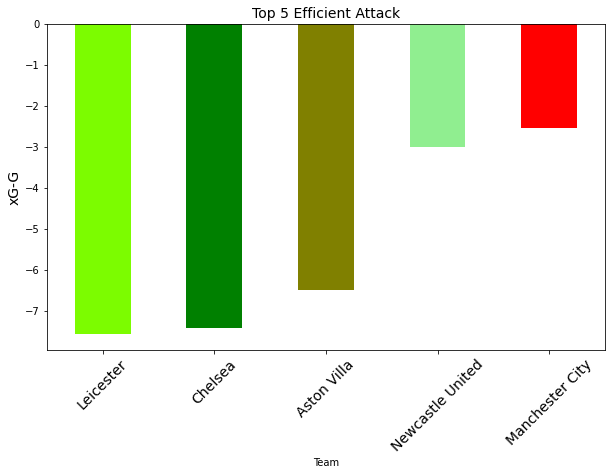

In [12]:
by = ['xG-G','xG']
iloc = team_columns[by[0]] - 1
filters = team_stats['xG-G'] <= 0
plot = team_stats.loc[filters,:].set_index(['Team'], drop = True).sort_values(by = by).iloc[:5,iloc]
plot.plot(kind = 'bar', color = [color_dict[team] for team in plot.index], figsize = (10,6))
plt.ylabel(plot.name, fontsize = 14)
plt.xticks(rotation = 45, fontsize = 14)
plt.title('Top 5 Efficient Attack', fontsize = 14)
plt.show()

# Visualize Top 5 Efficient Defence

A top defense as defined in this analysis is a team with less goals conceded than expected at best and same goals conceded as expected at worst

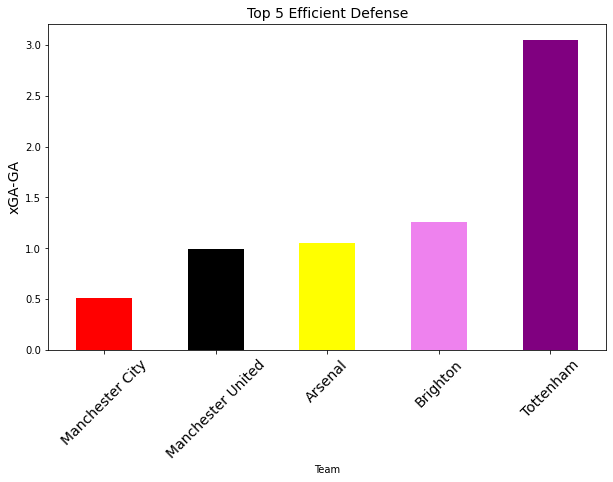

In [13]:
by = ['xGA-GA','xGA']
iloc = team_columns[by[0]] - 1
filters = team_stats['xGA-GA'] >= 0
plot = team_stats.loc[filters,:].set_index(['Team'], drop = True).sort_values(by = by, ascending = (True,False)).iloc[:5,iloc]
plot.plot(kind = 'bar', color = [color_dict[team] for team in plot.index], figsize = (10,6))
plt.xticks(rotation = 45, fontsize = 14)
plt.title('Top 5 Efficient Defense', fontsize = 14)
plt.ylabel(plot.name, fontsize = 14)
plt.show()

# Visualize Bottom 5 Efficient Attack

In this visualization, the team that score far less goals than expected are shown

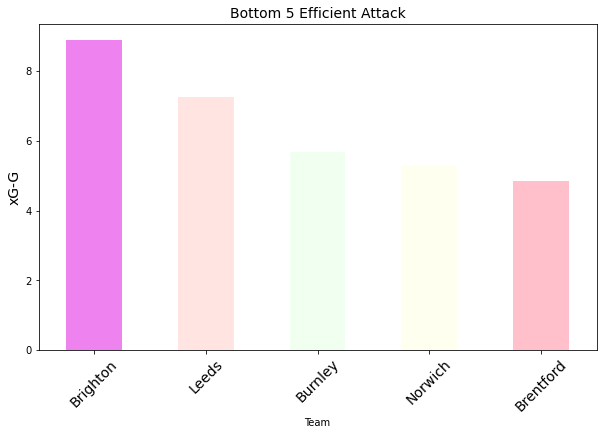

In [14]:
by = ['xG-G']
iloc = team_columns[by[0]] - 1
filters = team_stats['xG-G'] >= 0
plot = team_stats.loc[filters,:].set_index(['Team'], drop = True).sort_values(by = by, ascending = False).iloc[:5,iloc]
plot.plot(kind = 'bar', color = [color_dict[team] for team in plot.index], figsize = (10,6))
plt.ylabel(plot.name, fontsize = 14)
plt.xticks(rotation = 45, fontsize = 14)
plt.title('Bottom 5 Efficient Attack', fontsize = 14)
plt.show()

# Visualize Bottom 5 Efficient Defence

A top defense as defined in this analysis is a team with more goals conceded than expected

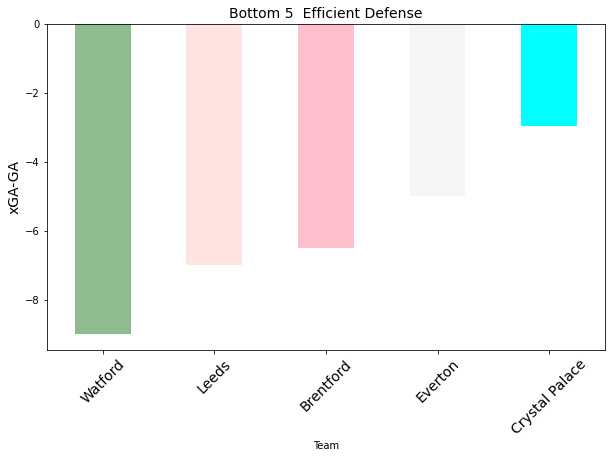

In [15]:
by = ['xGA-GA']
iloc = team_columns[by[0]] - 1
filters = team_stats['xGA-GA'] <= 0
plot = team_stats.loc[filters,:].set_index(['Team'], drop = True).sort_values(by = by).iloc[:5,iloc]
plot.plot(kind = 'bar', color = [color_dict[team] for team in plot.index], figsize = (10,6))
plt.xticks(rotation = 45, fontsize = 14)
plt.title('Bottom 5  Efficient Defense', fontsize = 14)
plt.ylabel(plot.name, fontsize = 14)
plt.show()

# Visualize Top 5 Attack

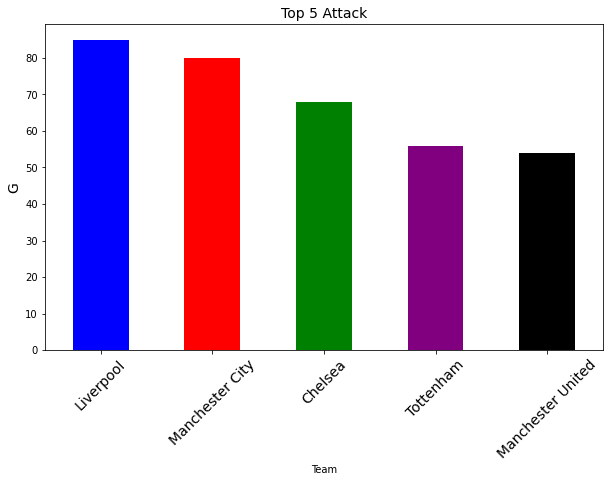

In [16]:
by = ['G','xG']
iloc = team_columns[by[0]] - 1
plot = team_stats.set_index(['Team'], drop = True).sort_values(by = by, ascending = False).iloc[:5,iloc]
plot.plot(kind = 'bar', color = [color_dict[team] for team in plot.index], figsize = (10,6))
plt.ylabel(plot.name, fontsize = 14)
plt.xticks(rotation = 45, fontsize = 14)
plt.title('Top 5 Attack', fontsize = 14)
plt.show()

# Visualize Top 5 Defence

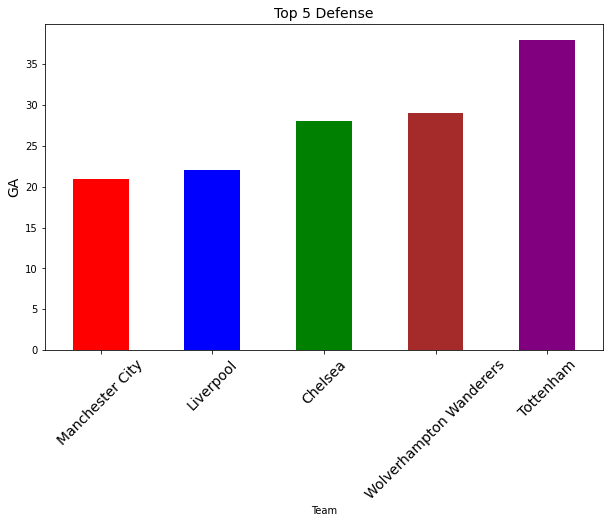

In [17]:
by = ['GA','xGA']
iloc = team_columns[by[0]] - 1
plot = team_stats.set_index(['Team'], drop = True).sort_values(by = by).iloc[:5,iloc]
plot.plot(kind = 'bar', color = [color_dict[team] for team in plot.index], figsize = (10,6))
plt.xticks(rotation = 45, fontsize = 14)
plt.title('Top 5 Defense', fontsize = 14)
plt.ylabel(plot.name, fontsize = 14)
plt.show()

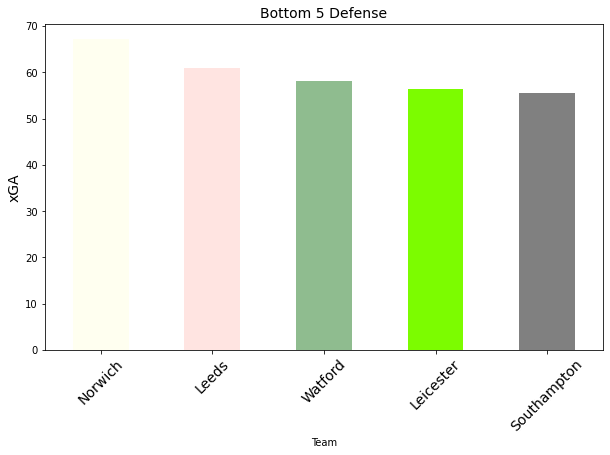

In [18]:
by = ['xGA','GA']
iloc = team_columns[by[0]] - 1
plot = team_stats.set_index(['Team'], drop = True).sort_values(by = by, ascending = False).iloc[:5,iloc]
plot.plot(kind = 'bar', color = [color_dict[team] for team in plot.index], figsize = (10,6))
plt.xticks(rotation = 45, fontsize = 14)
plt.title('Bottom 5 Defense', fontsize = 14)
plt.ylabel(plot.name, fontsize = 14)
plt.show()